# IMPORTS

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime
from statsmodels.stats.weightstats import DescrStatsW

## Definitions

In [3]:
# Set Seaborn configurations
sns.set_palette('Accent')
sns.set_style('darkgrid')


# standard font for plots
def std_font(ax1, title, xlabel, ylabel):
    ax1.set_title(title, loc='left', fontdict={'fontsize': 18}, pad=20)
    ax1.set_xlabel(xlabel, fontdict={'fontsize': 12, 'style': 'italic'})
    ax1.set_ylabel(ylabel, fontdict={'fontsize': 12, 'style': 'italic'})
    return None

## Loading Data

In [4]:
df_raw = pd.read_csv('kc_house_data.csv', parse_dates=['date'])

# DATA DESCRIPTION

## Data Preview

In [5]:
df_raw.head(3)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062


## Data Format and Types

In this dataset we don't have NA values. So we will skip the step of NA checking and treatment.

In [6]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             21613 non-null  int64         
 1   date           21613 non-null  datetime64[ns]
 2   price          21613 non-null  float64       
 3   bedrooms       21613 non-null  int64         
 4   bathrooms      21613 non-null  float64       
 5   sqft_living    21613 non-null  int64         
 6   sqft_lot       21613 non-null  int64         
 7   floors         21613 non-null  float64       
 8   waterfront     21613 non-null  int64         
 9   view           21613 non-null  int64         
 10  condition      21613 non-null  int64         
 11  grade          21613 non-null  int64         
 12  sqft_above     21613 non-null  int64         
 13  sqft_basement  21613 non-null  int64         
 14  yr_built       21613 non-null  int64         
 15  yr_renovated   2161

## Discriptive Statistics

 Now that we have some statistics for our data, let's check for possible anomalies and points of attention:
 
 - Price, sqft_above and sqft_basement has a considerable max-min interval, this can indicate possible outliers. So we must be aware of it.
 
 - We detected a house with 33 bedrooms (which is a lot, isnt it?). since the average is 3.37, we are probably facing an error in the data
 
 - We noticed that sqft_lot has a huge kurtosis value and a high skew value. This means that most of the sqft_lot data lives in a narrow range of values wich are located in the initial quantiles.
 
 - From the statistics, we can affirm that most of the houses are not waterfront.
 
 - We have the value zero in the yr_renovated feature. This probably means that the house has never been renovated.
 
 - There are some houses with no bedrooms and no bathrooms. Since we don't have a business team to debate this matter, we will consider that these cases are properties that have not yet finished building the house. This way they will have sqft_living and sqft_lot to continue building it.
 

In [7]:
# numerical attributes
df_raw_num_att = df_raw.select_dtypes(include=['int64', 'float64'])

# getting skew
skew = pd.DataFrame(df_raw_num_att.apply(lambda x: x.skew())).round(2).T
skew.rename(index={0: 'skew'}, inplace=True)

# getting kurtosis
kurtosis = pd.DataFrame(df_raw_num_att.apply(lambda x: x.kurtosis())).round(2).T
kurtosis.rename(index={0: 'kurtosis'}, inplace=True)

# numerical features 
describe = df_raw.describe().round(2)
m = pd.concat([describe, skew, kurtosis], axis=0)
m.iloc[:,1:]

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00
mean,540088.14,3.37,2.11,2079.90,15106.97,1.49,0.01,0.23,3.41,7.66,1788.39,291.51,1971.01,84.40,98077.94,47.56,-122.21,1986.55,12768.46
std,367127.20,0.93,0.77,918.44,41420.51,0.54,0.09,0.77,0.65,1.18,828.09,442.58,29.37,401.68,53.51,0.14,0.14,685.39,27304.18
min,75000.00,0.00,0.00,290.00,520.00,1.00,0.00,0.00,1.00,1.00,290.00,0.00,1900.00,0.00,98001.00,47.16,-122.52,399.00,651.00
25%,321950.00,3.00,1.75,1427.00,5040.00,1.00,0.00,0.00,3.00,7.00,1190.00,0.00,1951.00,0.00,98033.00,47.47,-122.33,1490.00,5100.00
50%,450000.00,3.00,2.25,1910.00,7618.00,1.50,0.00,0.00,3.00,7.00,1560.00,0.00,1975.00,0.00,98065.00,47.57,-122.23,1840.00,7620.00
75%,645000.00,4.00,2.50,2550.00,10688.00,2.00,0.00,0.00,4.00,8.00,2210.00,560.00,1997.00,0.00,98118.00,47.68,-122.12,2360.00,10083.00
max,7700000.00,33.00,8.00,13540.00,1651359.00,3.50,1.00,4.00,5.00,13.00,9410.00,4820.00,2015.00,2015.00,98199.00,47.78,-121.32,6210.00,871200.00
skew,4.02,1.97,0.51,1.47,13.06,0.62,11.39,3.40,1.03,0.77,1.45,1.58,-0.47,4.55,0.41,-0.49,0.89,1.11,9.51
kurtosis,34.59,49.06,1.28,5.24,285.08,-0.48,127.63,10.89,0.53,1.19,3.40,2.72,-0.66,18.70,-0.85,-0.68,1.05,1.60,150.76


# QUESTIONS & HYPOTHESIS

This chapter is a simulation of an output after a kickoff meeting with the business team, data team, stakeholders and others. In this meeting, some questions was highlighted and the data team must answer these questions untill the next meeting. 

**1.** On average, a higher square footage of the land space leads to higher house prices?

**2.** On average, a higher square footage of the interior living space leads to higher house prices?

**3.** How the number of bathrooms and bedrooms affects the house prices?

**4.** On average, when is the best time (month or season) to sell and to buy a house?

**5.** Does the neighborhood average interior sq. ft. affects the house price?

**6.** On average, houses with basement are 30% more expensive than those without it.

**7.** Houses with condition 5 are 15% more expensive than average.

**8.** Waterfront houses are 20% more expensive than those that are not waterfront.

**9.** On average, renovated houses are 25% more expensive than not renovated ones.

**10.** For each grade level (construction and design) the house price increases by 12%.

**11.** For each view level the house price increases by 5%.




# DATAFRAME FILTERING

For this dataset, I am assuming that the house with 33 bedrooms is a case of MCAR (Missing Completely at Random). So, the removal of this data will not add bias to our dataset.

In [8]:
# Removing the house with 33 bedrooms
aux2 = df_raw[df_raw['bedrooms'] < 33]

# FEATURE ENGINEERING

To properly answer the highlighted questions and hypothesis we need to manipulate our dataset, creating new features:

In [9]:
# Creating feature 'renovated'
aux2.insert(len(aux2.columns), 'renovated',
            aux2.loc[:, 'yr_renovated'].apply(lambda x: 1 if x > 0 else 0))

# Creating feature year_month
aux2.insert(len(aux2.columns), 'year_month',
            aux2.loc[:, 'date'].dt.strftime('%Y-%m'))

# Creating feature year_week
aux2.insert(len(aux2.columns), 'year_week',
            aux2.loc[:, 'date'].dt.strftime('%Y-%U'))

# creating feature sqft_ratio
aux2.insert(len(aux2.columns), 'sqft_ratio',
            aux2.loc[:, 'sqft_living'] / aux2.loc[:, 'sqft_living15'])

# EXPLORATORY DATA ANALYSIS

## Univariate Analysis

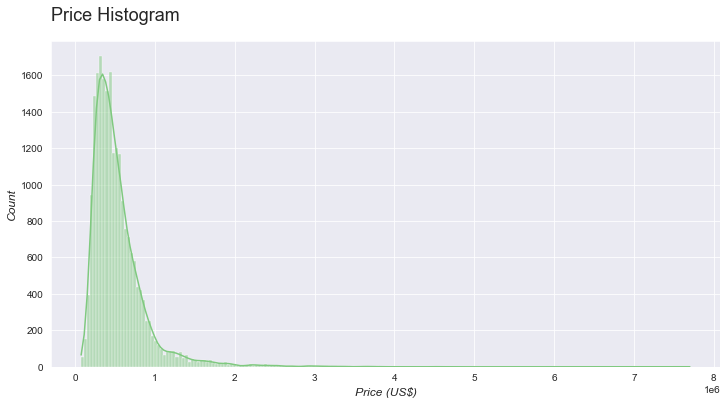

In [10]:
plt.figure(figsize=(12, 6))
ax1 = sns.histplot(data=aux2['price'], kde=True, bins=200)
std_font(ax1, 'Price Histogram', 'Price (US$)', 'Count')

## Bivariate Analysis

### On average, a higher square footage of the land space leads to higher house prices?
**FALSE** - There is no solid relation between the price and the square footage of the land space. The are plenty of houses with low square footage of the land space but with a high price. This will be reafirmed in section 6.3, when we get a very low correlation* value between these two features. 

*Correlation = 0.09

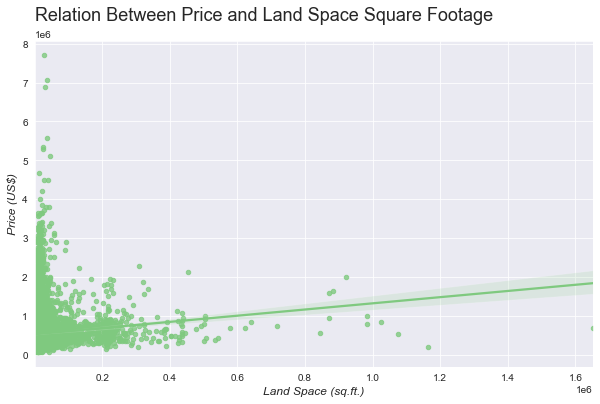

In [11]:
# 1)
plt.figure(figsize=(10, 6))
ax1 = sns.regplot(data=aux2, x='sqft_lot', y='price', scatter_kws={"s": 20})
std_font(ax1, 'Relation Between Price and Land Space Square Footage',
         'Land Space (sq.ft.)', 'Price (US$)')


### On average, a higher square footage of the interior living space leads to higher house prices?
**TRUE** - From the chart below we can see a strong relation between the price and the interior living space. This relation will be reafirmed in section 6.3 when we get a high correlation* value between these two features.

*Correlation = 0.70

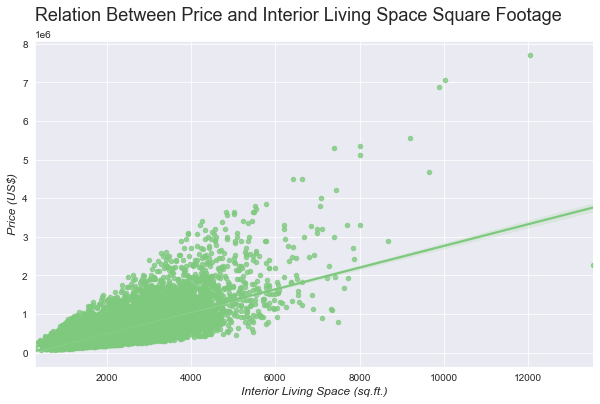

In [12]:
# 2)
plt.figure(figsize=(10, 6))
ax1 = sns.regplot(data=aux2, x='sqft_living', y='price', scatter_kws={"s": 20})
std_font(ax1, 'Relation Between Price and Interior Living Space Square Footage',
         'Interior Living Space (sq.ft.)', 'Price (US$)')


### How the number of bathrooms and bedrooms affects the house prices?
As we can see in the charts below, bedrooms are high correlated while bathrooms are slightly to nothing correlated. This will be reafirmed in section 6.3, where we can see the correlation* values.

*Correlation for bedrooms = 0.32

*Correlation for bathrooms = 0.53

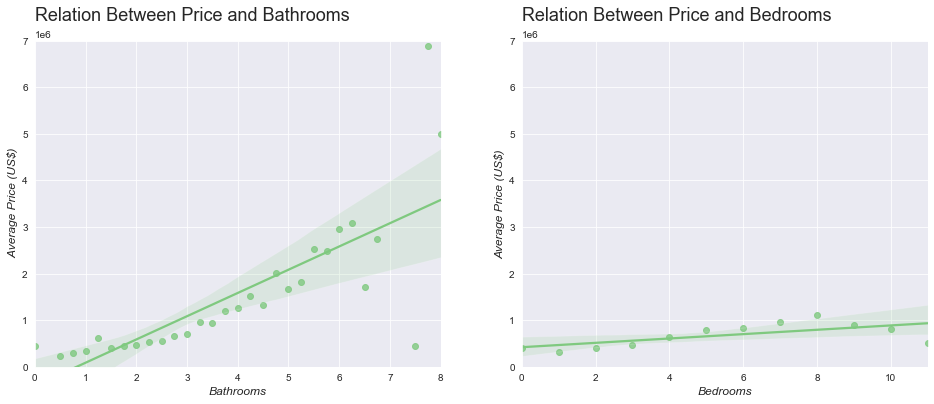

In [58]:
# 3)

# Aggregating features
bedroom = aux2[['bedrooms', 'price']].groupby('bedrooms').mean().reset_index()
bathroom = aux2[['bathrooms', 'price']].groupby(
    'bathrooms').mean().reset_index()

# Bed and bath plotting
plt.figure(figsize=(16, 6))
ax1 = plt.subplot(1, 2, 1)
plot1 = sns.regplot(data=bathroom, x="bathrooms", y="price")
std_font(plot1, 'Relation Between Price and Bathrooms',
         'Bathrooms', ' Average Price (US$)')
a = plot1.set_ylim(-1, 7000000)

ax2 = plt.subplot(1, 2, 2)
plot2 = sns.regplot(data=bedroom, x="bedrooms", y="price")
std_font(plot2, 'Relation Between Price and Bedrooms',
         'Bedrooms', 'Average Price (US$)')
b = plot2.set_ylim(-1, 7000000)


### On average, when is the best time (month or season) to sell and to buy a house?
The months where the houses are cheaper are from november to february, which is exactly on winter. The months where the houses are more expensive are from april to june, which is on spring and summer.

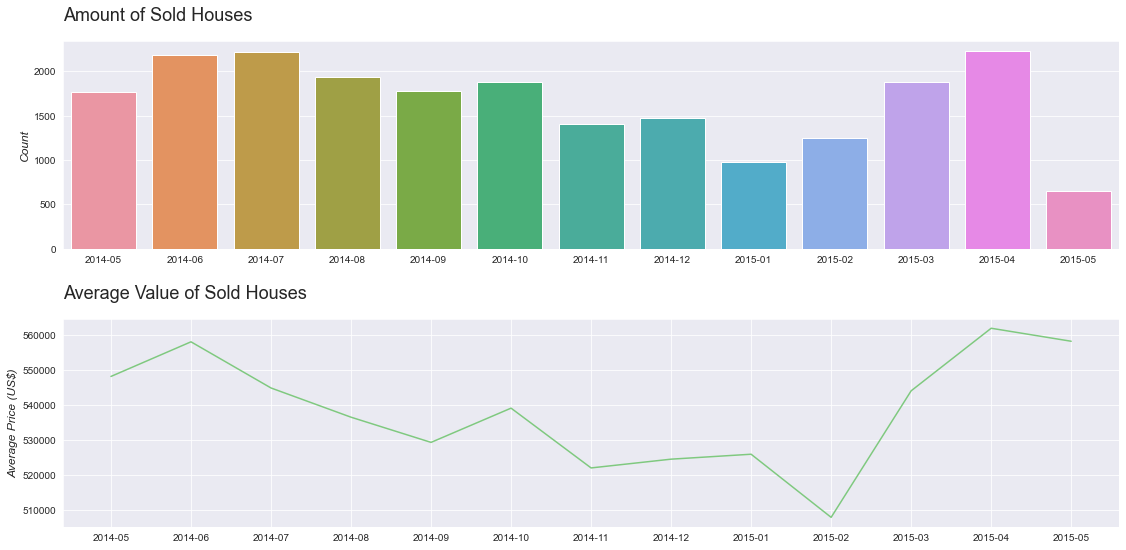

In [14]:
# 4) 

# Aggregating features
count_year_month = aux2[['year_month','price']].groupby('year_month').count().reset_index()
average_year_month = aux2[['year_month','price']].groupby('year_month').mean().reset_index()

# Plotting
plt.figure(figsize=(16,8), tight_layout={'pad':2.0})
ax1 = plt.subplot(2,1,1)
ax = sns.barplot(data=count_year_month, x='year_month', y='price')
std_font(ax, 'Amount of Sold Houses', '', 'Count')

ax2 = plt.subplot(2,1,2)
sns.lineplot(data=average_year_month, x='year_month', y='price')
std_font(ax2, 'Average Value of Sold Houses', '', 'Average Price (US$)')



### Does the neighborhood average interior sq. ft. affects the house price?
**TRUE** - From the data and the charts, we can say that neighborhood average interior sq. ft. has a medium to high importance* on the price. But the same cannot be told about the contrast of the interior sq. ft. of the house itself, compared to its neighbors. This relation has low effect on the price. We'll see the difference in section 6.3.

*Correlation for neighborhood average interior sq. ft. = 0.59

*Correlation for Square Footage Ratio = 0.30

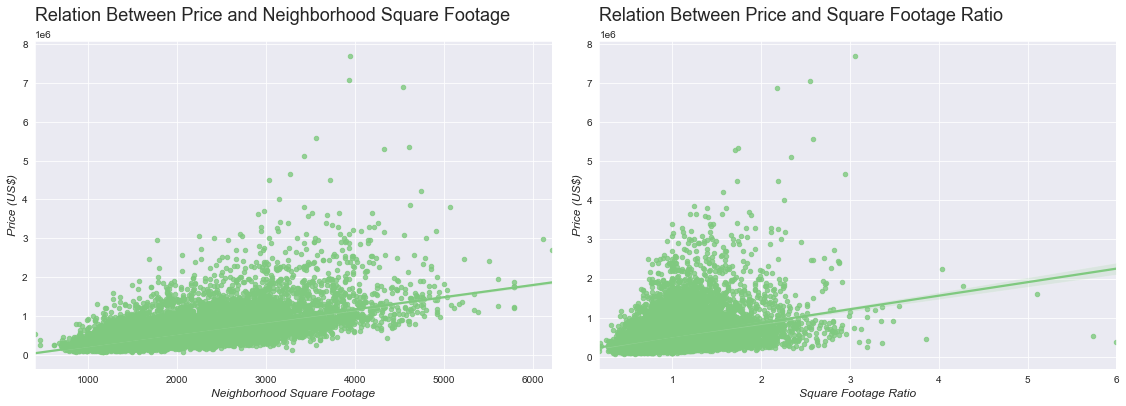

In [68]:
# 5)

plt.figure(figsize=(16, 6), tight_layout={'pad':2.0})
ax1 = plt.subplot(1,2,1)
ax = sns.regplot(data=aux2, x='sqft_living15', y='price', scatter_kws={"s": 20})
std_font(ax, 'Relation Between Price and Neighborhood Square Footage',
         'Neighborhood Square Footage', 'Price (US$)')

ax2 = plt.subplot(1, 2, 2)
ax = sns.regplot(data=aux2, x='sqft_ratio', y='price', scatter_kws={"s": 20})
std_font(ax, 'Relation Between Price and Square Footage Ratio',
         'Square Footage Ratio', 'Price (US$)')


### On average, houses with basement are 30% more expensive than those without it.
**TRUE** - The data shows us that houses with basement are 28% more expensive then the others who don't. Another analysis that can be made is that, for those houses which have basement, how its square footage affects the price? As we can see in the correlation chart, this feature has low to medium relation. 

In [16]:
# 6)

# Aggregating features
avg_with_basement = aux2.query('sqft_basement > 0')['price'].mean()
avg_without_basement = aux2.query('sqft_basement == 0')['price'].mean()

print('avg_with_basement / avg_without_basement = ',
      round(avg_with_basement / avg_without_basement, 2))

# Finding correlation
print('\n\nCorrelation between price and houses that have basement: ')
with_basement = aux2.query('sqft_basement > 0')[['price', 'sqft_basement']]
with_basement.corr()

avg_with_basement / avg_without_basement =  1.28


Correlation between price and houses that have basement: 


,price,sqft_basement
price,1.000000,0.407314
sqft_basement,0.407314,1.000000


### Houses with condition 5 are 15% more expensive than average.
**TRUE** - Houses with condition 5 is 13% more expensive than average. From the chart below, we see that the average price for conditions 1 and 2 are very close to each other. The same can be seen in conditions 3 and 4. To make sure that these averages are different (or equal) we will proceed with a hypothesis test:

 - Test 1: Since the p-value is higher than a 5% level of significance, we cannot reject the null hypothesis. So, with a 95% level of confidence, we can say that the averages of conditions 1 and 2 are the same.
 
 - Test 2: Since the p-value is lower than a 5% level of significance, we will reject the null hypothesis. So, with a 95% level of confidence, we can say that the average of condition 3 is higher than average of condition 4.

avg_cond_5 / avg_conds =  1.13

P-value of the test1:  0.8848

P-value of the test2:  0.0001


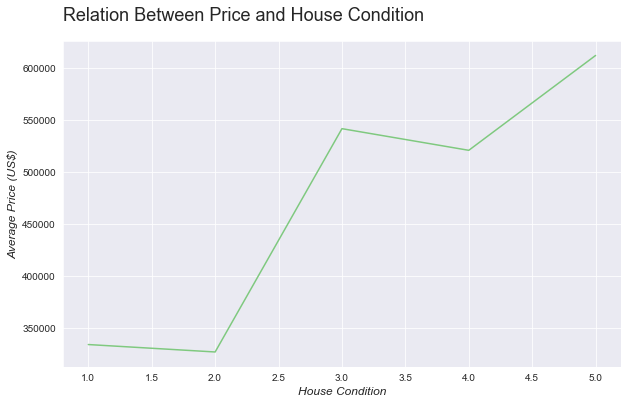

In [69]:
# 7)

# Aggregating features
avg_conds = aux2.query('condition <= 5')['price'].mean()
avg_cond_5 = aux2.query('condition == 5')['price'].mean()
conditions = aux2[['price', 'condition']].groupby('condition').mean().reset_index()

print('avg_cond_5 / avg_conds = ', round(avg_cond_5 / avg_conds, 2))

# Plotting
plt.figure(figsize=(10, 6))
ax1 = sns.lineplot(data=conditions, x='condition', y='price')
std_font(ax1, 'Relation Between Price and House Condition',
         'House Condition', 'Average Price (US$)')

# Creating variables to hypothesis testing
condition_1 = aux2.query('condition == 1')['price']
condition_2 = aux2.query('condition == 2')['price']
condition_3 = aux2.query('condition == 3')['price']
condition_4 = aux2.query('condition == 4')['price']

# Instancing
test_condition_1 = DescrStatsW(condition_1)
test_condition_2 = DescrStatsW(condition_2)
test_condition_3 = DescrStatsW(condition_3)
test_condition_4 = DescrStatsW(condition_4)

# Hypothesis testing
test1 = test_condition_1.get_compare(test_condition_2)
print('\nP-value of the test1: ',round(test1.ztest_ind(alternative='two-sided')[1],4))

test2 = test_condition_3.get_compare(test_condition_4)
print('\nP-value of the test2: ',round(test2.ztest_ind(alternative='larger')[1],4))

### Waterfront houses are 20% more expensive than those that are not waterfront.
**FALSE** - The waterfront houses are more than 200% more expensive than non waterfront houses.

In [18]:
# 8)
price_waterfront = aux2[['price', 'waterfront']
                        ].groupby('waterfront').mean()

print('price_waterfront / price_not_waterfront = ',
      round(price_waterfront.iloc[1, 0] / price_waterfront.iloc[0, 0], 2))

price_waterfront / price_not_waterfront =  3.13


### On average, renovated houses are 25% more expensive than not renovated ones.
**FALSE** - Renovated houses are 43% more expensive than not renovated ones.

In [19]:
# 9)
renovated = aux2[['price', 'renovated']].groupby('renovated').mean()
print('renovated / not_renovated = ',round(renovated.iloc[1,0] / renovated.iloc[0,0], 2))

renovated / not_renovated =  1.43


### For each grade level (construction and design) the house price increases by 12%.
**FALSE** - The increase in price do not follow a linear relation, so, an increase by 12% for each grade level is not possible. As we can see in the plot below, the behavior of this relation is close to an exponencial.

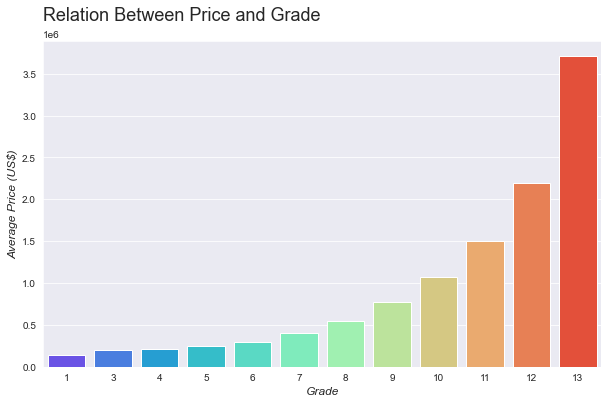

In [20]:
# 10) 

# Aggregating features
grade_price = aux2[['price','grade']].groupby('grade').mean().reset_index()

# Plotting
plt.figure( figsize=(10, 6) )
ax1 = sns.barplot(data=grade_price, x='grade', y='price', palette='rainbow')
std_font(ax1, 'Relation Between Price and Grade', 'Grade', 'Average Price (US$)')

### For each view level the house price increases by 5%.
**FALSE** - The increase in price do not follow a linear relation, so, an increase by 5% for each grade level is not possible. From the chart below, we see that the average price for views 1 and 2 are very close to each other. To make sure that these averages are different (or equal) we will proceed with a hypothesis test:

Test: Since the p-value is higher than a 5% level of significance, we cannot reject the null hypothesis. So, with a 95% level of confidence, we can say that the averages of views 1 and 2 are the same.


P-value of the test:  0.5405


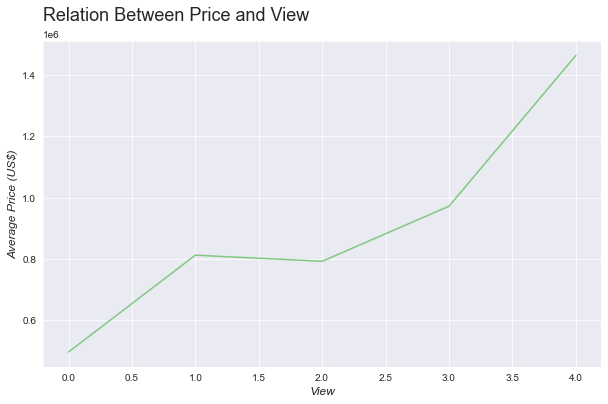

In [28]:
# 11)

# Aggregating features
view_price = aux2[['price', 'view']].groupby('view').mean().reset_index()

# Plotting
plt.figure(figsize=(10, 6))
ax1 = sns.lineplot(data=view_price, x='view', y='price')
std_font(ax1, 'Relation Between Price and View', 'View', 'Average Price (US$)')

# Creating variables to hypothesis testing
view_1 = aux2.query('view == 1')['price']
view_2 = aux2.query('view == 2')['price']

# Instancing
test_view_1 = DescrStatsW(view_1)
test_view_2 = DescrStatsW(view_2)

# Hypothesis Test
test = test_view_1.get_compare(test_view_2)
print('\nP-value of the test: ',round(test.ztest_ind(alternative='two-sided')[1], 4))

### Extra analysis

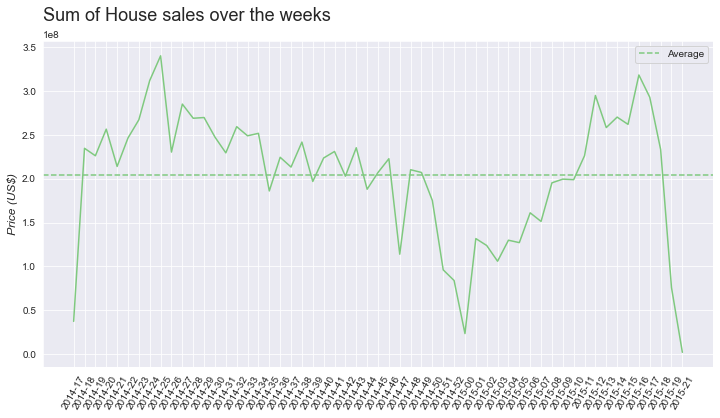

In [44]:
# extra 

# Aggregating features
sales_week = aux2[['price', 'year_week']].groupby('year_week').sum().reset_index()
average_sales = aux2[['price', 'year_week']].groupby('year_week').sum()['price'].mean()

# Plotting
plt.figure( figsize=(12, 6) )
plt.axhline( average_sales, linestyle='--', label='Average')
ax1 = sns.lineplot(data=sales_week.sort_values('year_week'), x='year_week', y='price', ci=None)
std_font(ax1, 'Sum of House sales over the weeks', '', 'Price (US$)')
a = plt.xticks(rotation=60)

## Multivariate Analysis

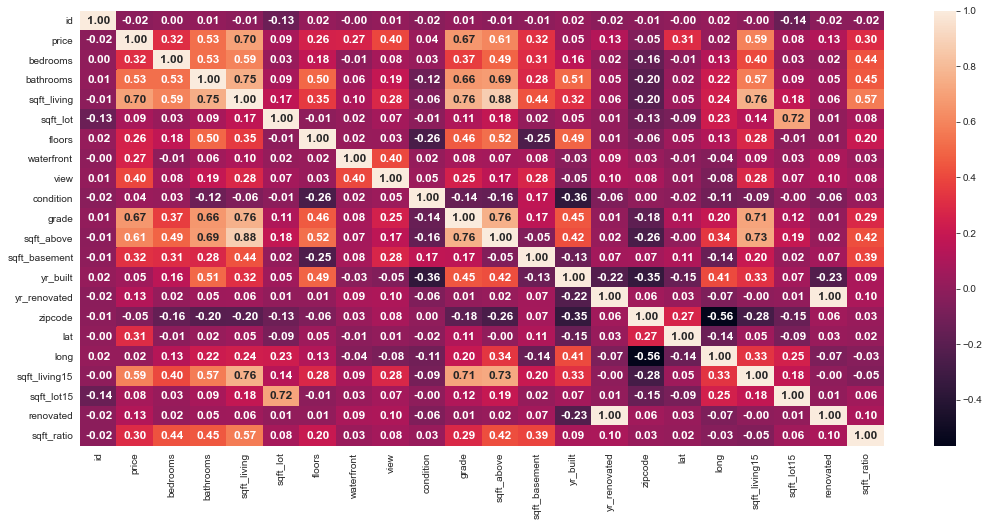

In [23]:
correlation = aux2.corr(method='pearson')
plt.figure( figsize=(18, 8) )
sns.heatmap(data=correlation, annot=True, fmt='.2f', annot_kws={'fontsize':12, 'fontweight':'bold'})
ax=ax

# OVERVIEW AND NEXT STEPS

- Gather more information about house sales in other years in order to get time based insights

- Gather information about the costs to increase the house view, construction of bathrooms, house renovation, construction of basement.